In [1]:
import pandas as pd
# import kaleido # 显示svg图片
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime


plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

# 1. 数据预处理

In [2]:
df = pd.read_csv('data/order_train1.csv')
df['order_date'] = pd.to_datetime(df['order_date']) # 将order_date列转化为datetime64类型
# 提取日期信息及格式化输出
df['year'] = df['order_date'].dt.year
df['quarter'] = df['order_date'].dt.quarter
df['month'] = df['order_date'].dt.month
df['week'] = df['order_date'].dt.isocalendar().week
df['weekday'] = df['order_date'].dt.dayofweek
df['day'] = df['order_date'].dt.day
df['monthly_date'] = df['order_date'].dt.strftime('%Y-%m')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597694 entries, 0 to 597693
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   order_date         597694 non-null  datetime64[ns]
 1   sales_region_code  597694 non-null  int64         
 2   item_code          597694 non-null  int64         
 3   first_cate_code    597694 non-null  int64         
 4   second_cate_code   597694 non-null  int64         
 5   sales_chan_name    597694 non-null  object        
 6   item_price         597694 non-null  float64       
 7   ord_qty            597694 non-null  int64         
 8   year               597694 non-null  int32         
 9   quarter            597694 non-null  int32         
 10  month              597694 non-null  int32         
 11  week               597694 non-null  UInt32        
 12  weekday            597694 non-null  int32         
 13  day                597694 non-null  int32   

In [4]:
df.describe()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,item_price,ord_qty,year,quarter,month,week,weekday,day
count,597694,597694.000000,597694.000000,597694.000000,597694.000000,597694.000000,597694.000000,597694.000000,597694.000000,597694.000000,597694.0,597694.000000,597694.000000
mean,2017-07-24 07:00:21.044882688,102.903949,21008.015983,304.932094,406.457174,1076.241578,91.650505,2017.013482,2.677703,7.060795,29.026987,2.970980,16.902278
min,2015-09-01 00:00:00,101.000000,20001.000000,301.000000,401.000000,1.000000,1.000000,2015.000000,1.000000,1.000000,1.0,0.000000,1.000000
25%,2016-10-31 00:00:00,102.000000,20518.000000,303.000000,404.000000,598.000000,10.000000,2016.000000,2.000000,4.000000,16.0,1.000000,10.000000
50%,2017-08-24 00:00:00,103.000000,20976.000000,306.000000,407.000000,883.000000,29.000000,2017.000000,3.000000,8.000000,32.0,3.000000,17.000000
75%,2018-05-15 00:00:00,105.000000,21521.000000,306.000000,408.000000,1291.000000,101.000000,2018.000000,4.000000,10.000000,43.0,5.000000,24.000000
max,2018-12-20 00:00:00,105.000000,22084.000000,308.000000,412.000000,260014.000000,16308.000000,2018.000000,4.000000,12.000000,53.0,6.000000,31.000000
std,NaN,1.504880,590.896347,2.004195,3.107329,1167.511104,199.843336,0.922004,1.136108,3.503173,15.297708,1.904604,8.399966


发现产品价格(item_price)和ord_qty(订单订货量)两列的上四分位数与最大值差别较大，可能存在异常数据

## 1.1 数据缺失重复值处理

### 1.1.1缺失值的处理

在数据缺失值的处理过程中，我们根据缺失值的变量的类型以及意义分为产品属性缺失值以及产品销售数据的缺失值，针对这两种数据，我们进行分别处理。

1. 针对产品属性的缺失值处理

   在数据探索的过程中，我们发现在某些订单日期存在数据缺失，企业在这些时期并未售出产品。缺失日期为2015 年 10 月 1 日 到 10 月 3 日，2016 年 1 月 1 日，2016 年 2 月 4 日到 2 月 14 日、2017 年 1 月 24 日到 2 月 2 日、2018 年 2 月 12 到 2 月 21 日，经查阅这些日期均为节假日，企业可能有国家节假日停工休产的行为，因此这些时期的数据我们认为符合逻辑，暂未进行补充。

   在销售地区、销售渠道的缺失情况下，我们拟选取同一产品类别中出现频次最高的数据（众数）进行编码填充，而产品编码、产品大类、产品细类为一一对应的关系，因此若存在单项缺失的情况，可以根据其他两个数据编码进行还原补充。如果数据同时缺失多项，考虑到样本数量较大、这类数据缺失情况较少，我们对这类数据删除处理。

2. 针对产品销售数据的缺失值处理

   处理存产品价格和产品需求缺失的数据时，我们回溯至缺失值附近日期，选取同一地区同一产品类别，观察近期前后几日产品销售数据情况，若无明显波动，则选取近期几日的平均销售数据填充；若销售数据有显著差异（可能为节假日，促销日等日期数据影响），则选取往年同时期或同节日的数据进行填充。

In [5]:
df.isnull().sum()

order_date           0
sales_region_code    0
item_code            0
first_cate_code      0
second_cate_code     0
sales_chan_name      0
item_price           0
ord_qty              0
year                 0
quarter              0
month                0
week                 0
weekday              0
day                  0
monthly_date         0
dtype: int64

In [6]:
# 产品编码、产品大类和销售细类缺失
# 参考：python里使用iterrows()对dataframe进行遍历(https://blog.csdn.net/weixin_38605247/article/details/78736417)
if (df['item_code'].isnull().sum() > 0) & (df['first_cate_code'].isnull().sum() > 0) & (df['second_cate_code'].isnull().sum() > 0):
    # 创建dataframe储存对应的元素
    product_df = df[['item_code','first_cate_code','second_cate_code']].copy()
    product_df.drop_duplicates(inplace=True)
    product_df.reset_index(inplace=True,drop=True)
    # product_df
    for index,row in df[['item_code','first_cate_code','second_cate_code']].iterrows():
        if row.isnull().sum() > 1:
            df.drop(index)
        elif row.isnull().sum() == 1:
            if pd.isna(row['item_code']):
                df.at[index,'item_code'] = product_df[(product_df['first_cate_code'] == df['first_cate_code']) & (product_df['second_cate_code'] == df['second_cate_code'])]
            if pd.isna(row['first_cate_code']):
                df.at[index,'first_cate_code'] = product_df[(product_df['item_code'] == df['item_code']) & (product_df['second_cate_code'] == df['second_cate_code'])]
            if pd.isna(row['second_cate_code']):
                df.at[index,'second_cate_code'] = product_df[(product_df['item_code'] == df['item_code']) & (product_df['first_cate_code'] == df['first_cate_code'])]

In [7]:
# 日期缺失值查找（订单的日期是否连续）
# 参考：Python数据分析，pandas对日期的处理(https://blog.csdn.net/2201_75362610/article/details/131240831)

# 创建一个包含所有日期的日期范围
date_range = pd.date_range(start=df['order_date'].min(), end=df['order_date'].max())

# 取反找到缺失的日期
missing_dates = date_range[~date_range.isin(df['order_date'])]

print(missing_dates)

DatetimeIndex(['2015-10-01', '2015-10-02', '2015-10-03', '2016-01-01',
               '2016-02-04', '2016-02-05', '2016-02-06', '2016-02-07',
               '2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11',
               '2016-02-12', '2016-02-13', '2016-02-14', '2017-01-24',
               '2017-01-25', '2017-01-26', '2017-01-27', '2017-01-28',
               '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01',
               '2017-02-02', '2018-02-12', '2018-02-13', '2018-02-14',
               '2018-02-15', '2018-02-16', '2018-02-17', '2018-02-18',
               '2018-02-19', '2018-02-20', '2018-02-21'],
              dtype='datetime64[ns]', freq=None)


In [8]:
df.duplicated().sum() # 显示重复行的数量
print(df.duplicated().sum())
df.drop_duplicates(inplace=True) # 在原始数据上去除重复行

312


## 1.2 数据异常值处理
思路：计算数值型数据所在列（如item_price, ord_qty）的分位数，根据以下表格的标准进行剔除

| 判断标准 | 数据类型 |
| ---- | ---- |
| $x>Q_3+1.5(Q_3 - Q1)$ 或者 $x<Q_1-1.5(Q_3 - Q1)$ | 异常点(type1) |
| $x>Q_3+3(Q_3 - Q1)$ 或者 $x<Q_1-3(Q_3 - Q1)$ | 极端异常点(type2) |


In [9]:
# 取反操作参考：pandas DataFrame 删除 / 选取含有特定数值的行或列(https://blog.csdn.net/sinat_26811377/article/details/107406714)
def outlier_handle(df,num_var_list,type):
    if type == 1:
        f = 1.5
    if type == 2:
        f = 3
        
    for i in num_var_list:
        Q3 = np.percentile(df[i],75)
        Q1 = np.percentile(df[i],25)
        delta = Q3 - Q1
        condition = (df[i]>Q3+f*delta) | (df[i]<Q1-f*delta)
        df = df[~condition]

    return df
    # return df[condition]
        

In [10]:
df = outlier_handle(df,['item_price','ord_qty'],2)
df.reset_index(inplace=True,drop=True)
df

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty,year,quarter,month,week,weekday,day,monthly_date
0,2015-09-01,104,22069,307,403,offline,1114.0,19,2015,3,9,36,1,1,2015-09
1,2015-09-01,104,20028,301,405,offline,1012.0,12,2015,3,9,36,1,1,2015-09
2,2015-09-02,104,21183,307,403,online,428.0,109,2015,3,9,36,2,2,2015-09
3,2015-09-02,104,20448,308,404,online,962.0,3,2015,3,9,36,2,2,2015-09
4,2015-09-02,104,21565,307,403,offline,1400.0,3,2015,3,9,36,2,2,2015-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557245,2018-12-20,102,21596,302,408,offline,1103.0,108,2018,4,12,51,3,20,2018-12
557246,2018-12-20,102,20994,302,408,offline,843.0,59,2018,4,12,51,3,20,2018-12
557247,2018-12-20,102,20215,302,408,offline,2013.0,106,2018,4,12,51,3,20,2018-12
557248,2018-12-20,102,20195,302,408,offline,2120.0,187,2018,4,12,51,3,20,2018-12


## 1.2 数据编码
### 1.2.1 销售渠道
销售渠道名称(sales_chan_name)：由于该字段数据类型为字符串，为便于后续的分析，按照以下方式对其编码
| 销售渠道名称 | 编号 |
| ---- | ---- |
| offline | 0 |
| online | 1 |

### 1.2.2 促销日
| 日期类型 | 日期 | 编号 |
| ---- | ---- | ---- |
| 非促销日 | 0 | 0 |
| 情人节 | 2.14 | 1 |
| 妇女节 | 3.8 | 2 |
| 618 | 6.18 | 3 |
| 国庆 | 10.1 | 4 |
| 双十一 | 11.11 | 5 |
| 双十二 | 12.12 | 6 |


In [11]:
# 销售渠道编码
sales_chan_name_code = {'offline':0,'online':1}
df['sales_chan_code'] = df['sales_chan_name'].apply(lambda x:sales_chan_name_code[x])

In [12]:
# 月份时间段
def assign_month_period(day):
    if day <= 10:
        return 1
    elif 10 < day <= 20:
        return 2
    else:
        return 3
df['month_period'] = df['day'].apply(assign_month_period)

In [13]:
# 节假日编码
# 字典get操作参考：https://www.runoob.com/python/att-dictionary-get.html
holidays_dict = {
    (2,14):1,
    (3,8):2,
    (6,18):3,
    (10,1):4,
    (11,11):5,
    (12,12):6
}

def assign_date_number(date):
    month_day = (date.month, date.day)
    return holidays_dict.get(month_day, 0)

df['sales_promotion_type'] = df['order_date'].apply(assign_date_number)
df['is sales promotion'] = df['sales_promotion_type'].apply(lambda x: 1 if x != 0 else 0)

In [14]:
# 节假日类型判断
holidays_dict = {
    1: set(pd.to_datetime(date) for date in ['2016-1-1','2016-1-2','2016-1-3','2017-12-31','2018-1-1','2018-1-2','2018-12-30','2018-12-31','2019-1-1']),  # 元旦
    2: set(
        pd.to_datetime(date) for date in ['2016-2-7','2016-2-8','2016-2-9','2016-2-10','2016-2-11','2016-2-12','2016-2-13','2017-1-27','2017-1-28','2017-1-29','2017-1-30','2017-1-31','2017-2-1','2017-2-2','2018-2-15','2018-2-16','2018-2-17','2018-2-18','2018-2-19','2018-2-20','2018-2-21']),  # 春节
    3: set(pd.to_datetime(date) for date in ['2016-4-3','2016-4-4','2016-4-5','2017-4-2','2017-4-3','2017-4-4','2018-4-5','2018-4-5','2018-4-6','2018-4-7']),  # 清明
    4: set(pd.to_datetime(date) for date in ['2016-5-1','2016-5-2','2016-5-3','2017-4-29','2017-4-30','2017-5-1','2018-4-29','2018-4-30','2018-5-1']),  # 劳动
    5: set(pd.to_datetime(date) for date in ['2016-6-9','2016-6-10','2016-6-11','2017-5-28','2017-5-29','2017-5-30','2018-6-16','2018-6-17','2018-6-18']),  # 端午
    6: set(pd.to_datetime(date) for date in ['2015-9-26','2015-9-27','2016-9-15','2016-9-16','2016-9-17','2017-10-4','2018-9-22','2018-9-23','2018-9-24']),  # 中秋
    7: set(pd.to_datetime(date) for date in ['2015-10-1','2015-10-2','2015-10-3','2015-10-4','2015-10-5','2015-10-6','2015-10-7','2016-10-1','2016-10-2','2016-10-3','2016-10-4','2016-10-5','2016-10-6','2016-10-7','2017-10-1','2017-10-2','2017-10-3','2017-10-5','2017-10-6','2017-10-7','2017-10-8','2018-10-1','2018-10-2','2018-10-3','2018-10-5','2018-10-6','2018-10-7','2018-10-8'])  # 国庆
}

def assign_holiday_type(date):
    for holiday_type, date_set in holidays_dict.items():
        if date in date_set:
            return holiday_type
    return 0

df['holiday_type'] = df['order_date'].apply(assign_holiday_type)
df['is_holiday'] = df['holiday_type'].apply(lambda x: 1 if x != 0 else 0)

In [15]:
# 判断dataframe order_date列属于那个季节 按照春夏秋冬顺序编号为1234
def assign_season(date):
    if date.month in [3,4,5]:
        return 1
    elif date.month in [6,7,8]:
        return 2
    elif date.month in [9,10,11]:
        return 3
    else:
        return 4
df['season'] = df['order_date'].apply(assign_season)

In [16]:
df

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty,year,quarter,...,weekday,day,monthly_date,sales_chan_code,month_period,sales_promotion_type,is sales promotion,holiday_type,is_holiday,season
0,2015-09-01,104,22069,307,403,offline,1114.0,19,2015,3,...,1,1,2015-09,0,1,0,0,0,0,3
1,2015-09-01,104,20028,301,405,offline,1012.0,12,2015,3,...,1,1,2015-09,0,1,0,0,0,0,3
2,2015-09-02,104,21183,307,403,online,428.0,109,2015,3,...,2,2,2015-09,1,1,0,0,0,0,3
3,2015-09-02,104,20448,308,404,online,962.0,3,2015,3,...,2,2,2015-09,1,1,0,0,0,0,3
4,2015-09-02,104,21565,307,403,offline,1400.0,3,2015,3,...,2,2,2015-09,0,1,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557245,2018-12-20,102,21596,302,408,offline,1103.0,108,2018,4,...,3,20,2018-12,0,2,0,0,0,0,4
557246,2018-12-20,102,20994,302,408,offline,843.0,59,2018,4,...,3,20,2018-12,0,2,0,0,0,0,4
557247,2018-12-20,102,20215,302,408,offline,2013.0,106,2018,4,...,3,20,2018-12,0,2,0,0,0,0,4
557248,2018-12-20,102,20195,302,408,offline,2120.0,187,2018,4,...,3,20,2018-12,0,2,0,0,0,0,4


In [17]:
# df.drop(['sales_chan_name','monthly_date'],axis=1).to_csv('data/处理后数据.csv')

# 2. 描述性统计

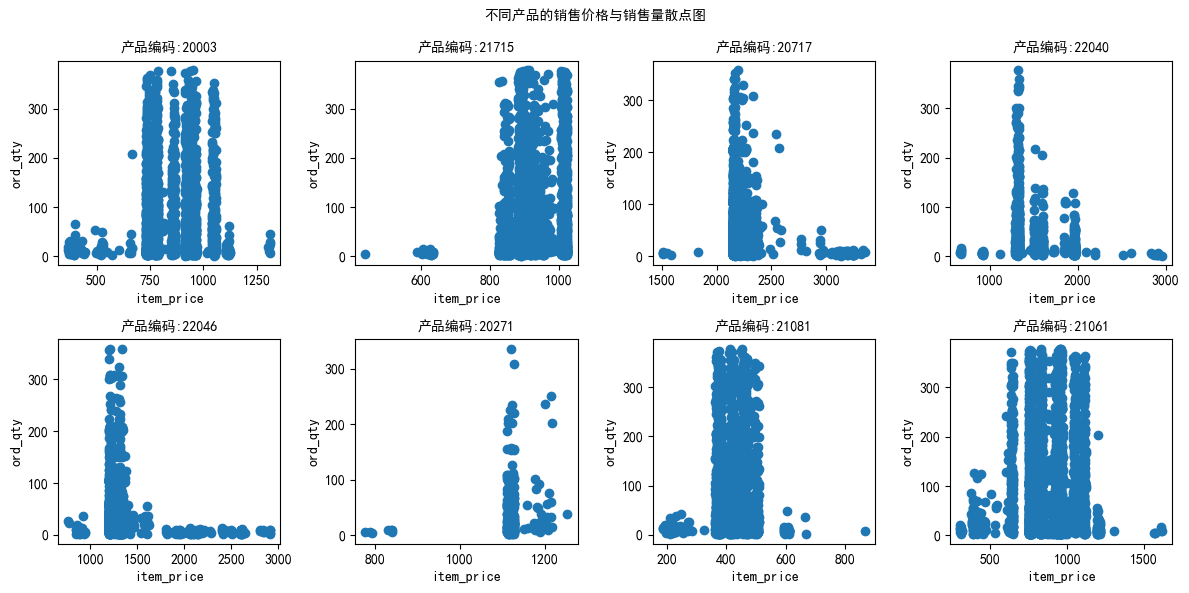

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
item_code_list = [20003,21715,20717,22040,22046,20271,21081,21061]

for i in range(2):
    for j in range(4):
        ax = axes[i,j]
        # 根据8个元素的item_code_list绘制对应大类产品的销售价格对销售量的散点图
        ax.scatter(df[df['item_code']==item_code_list[i*4+j]]['item_price'],df[df['item_code']==item_code_list[i*4+j]]['ord_qty'])
        ax.set_title(f'产品编码:{item_code_list[i*4+j]}',fontproperties = 'SimHei')
        ax.set_xlabel('item_price')
        ax.set_ylabel('ord_qty')

fig.suptitle('不同产品的销售价格与销售量散点图',fontproperties = 'SimHei')
plt.tight_layout()
# plt.subplots_adjust(top=0.85)
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


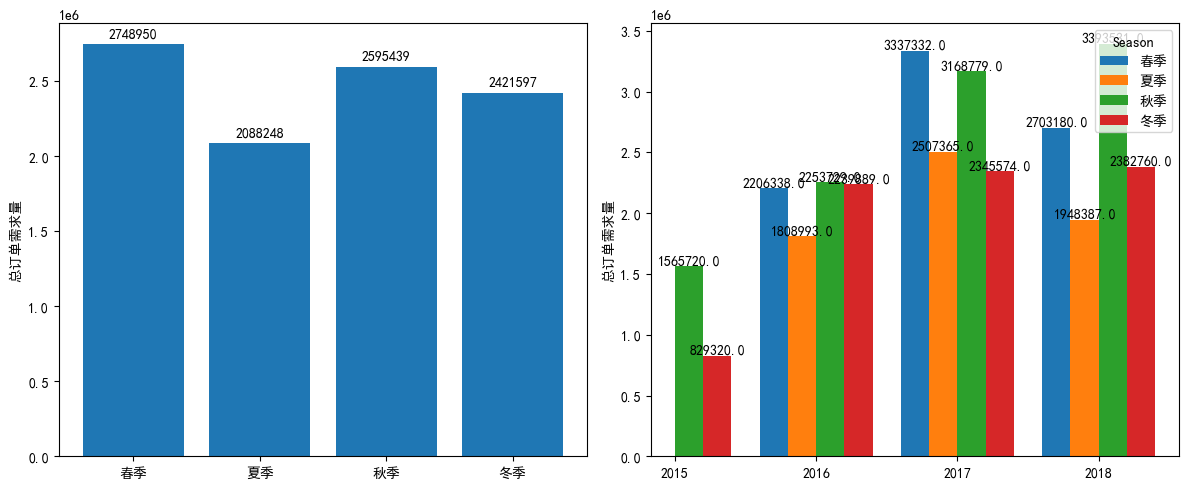

In [19]:
# 绘制
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 绘制左图
grouped_df = df.groupby('season').agg({'ord_qty':'sum'}).reset_index()
def cal_avg_qty(row):
    if row['season'] == 1:
        return row['ord_qty'] / 3
    elif row['season'] == 2:
        return row['ord_qty'] / 3
    elif row['season'] == 3:
        return row['ord_qty'] / 4
    else:
        return row['ord_qty'] / 3.22
grouped_df['avg_qty'] = grouped_df.apply(cal_avg_qty,axis=1)

# plt.figure(figsize=(10,6))
# plt.subplot(1,2,1)
ax[0].bar(grouped_df['season'],grouped_df['avg_qty'])
# 在每个数据项上标注具体的数据值
for x,y in zip(grouped_df['season'],grouped_df['avg_qty']):    
    ax[0].text(x,y+30000,'%d'%y,ha='center',va='bottom')
ax[0].set_xticks([1,2,3,4],['春季','夏季','秋季','冬季'],fontproperties='SimHei')
ax[0].set_ylabel('总订单需求量',fontproperties='SimHei')


# 绘制右图
grouped_df1 = df.groupby(['year','season']).agg({'ord_qty':'sum'}).reset_index()
season_mapping = {1: '春季', 2: '夏季', 3: '秋季', 4: '冬季'}
grouped_df1['season'] = grouped_df1['season'].replace(season_mapping)
grouped_df1 = grouped_df1.pivot(index='year',columns='season',values='ord_qty')
grouped_df1 = grouped_df1[['春季', '夏季', '秋季', '冬季']]
# grouped_df1
width = 0.2  # 柱形宽度

years = grouped_df1.index
seasons = grouped_df1.columns
num_quarters = len(seasons)
bar_width = 0.2
index = range(len(years))

for i, season in enumerate(seasons):
    positions = [x + i * bar_width for x in index]
    bars = ax[1].bar(positions, grouped_df1[season], width=width, label=season)
    for bar, value in zip(bars, grouped_df1[season]):
        ax[1].text(bar.get_x() + bar.get_width() / 2, value, str(value), ha='center', va='bottom')

# ax.set_xlabel('年份')
ax[1].set_ylabel('总订单需求量')
# ax[1].set_title('Quarterly Sales by Year')
ax[1].set_xticks([x + (num_quarters - 1) * bar_width / 2 for x in index])
ax[1].set_xticklabels(years)
ax[1].legend(title='Season')

plt.tight_layout()
plt.show()

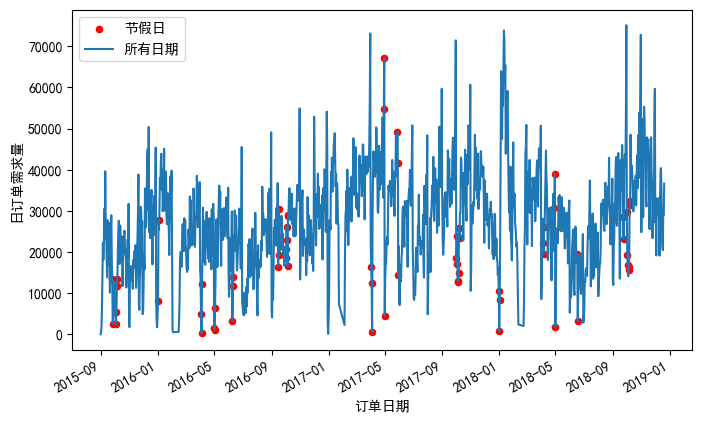

In [20]:
grouped_df = df.groupby('order_date').agg({'ord_qty': 'sum'}).reset_index()
merged_holiday_set = set().union(*holidays_dict.values())
# 判断对应日期是否为节假日
def is_holiday(date):
    if date in merged_holiday_set:
        return True
    else:
        return False
grouped_df['is_holiday'] = grouped_df['order_date'].apply(is_holiday)
plt.figure(figsize=(8,5))
# 标注节假日的数据点
holiday_legend_added = False
for index, row in grouped_df[grouped_df['is_holiday']].iterrows():
    plt.scatter(row['order_date'], row['ord_qty'], marker='.', color='red', s=80, label='节假日' if not holiday_legend_added else '')
    holiday_legend_added = True

plt.plot(grouped_df['order_date'],grouped_df['ord_qty'], label='所有日期')
plt.xlabel('订单日期')
plt.ylabel('日订单需求量')
plt.legend()
plt.gcf().autofmt_xdate()

plt.show()

In [21]:
# 统计不同类型日期的天数
date_type_df = df[['order_date','holiday_type']].drop_duplicates()
holidays_count_dict = date_type_df.groupby('holiday_type').agg({'order_date':'count'}).to_dict()['order_date']
holidays_count_dict

{0: 1105, 1: 5, 3: 9, 4: 9, 5: 9, 6: 9, 7: 25}

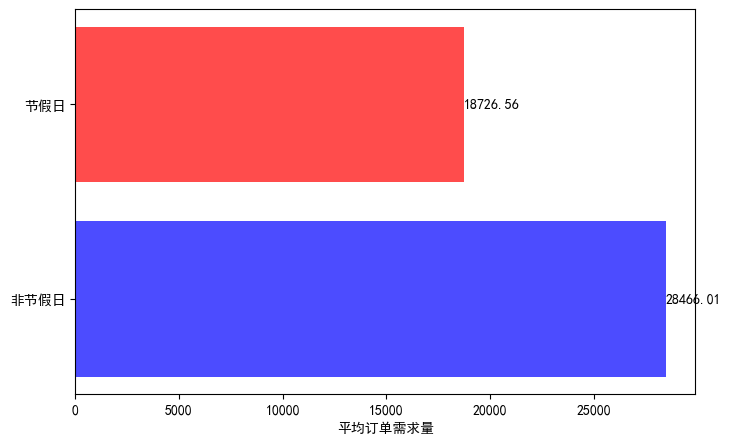

In [22]:
grouped_df = df.groupby('order_date').agg({'ord_qty':'sum'}).reset_index()
merged_holiday_set = set().union(*holidays_dict.values())
holidays_num = {0: holidays_count_dict.get(0,0),
                1: sum(v for k, v in holidays_count_dict.items() if k != 0)}
def is_holiday(date):
    if date in merged_holiday_set:
        return 1
    else:
        return 0

def cal_avg_qty(row):
    if row['is_holiday'] == 0:
        return row['ord_qty'] / holidays_num[0]
    else:
        return row['ord_qty'] / holidays_num[1]
grouped_df['is_holiday'] = grouped_df['order_date'].apply(is_holiday)
avg_demand_by_holiday = grouped_df.groupby('is_holiday')['ord_qty'].sum().reset_index()
avg_demand_by_holiday['avg_ord_qty'] = avg_demand_by_holiday.apply(cal_avg_qty,axis=1)
avg_demand_by_holiday = avg_demand_by_holiday.drop('ord_qty',axis=1).set_index('is_holiday')

plt.figure(figsize=(8, 5))
bars = plt.barh(['非节假日', '节假日'], avg_demand_by_holiday['avg_ord_qty'], color=['blue', 'red'], alpha=0.7)
for bar in bars:
    xval = bar.get_width()
    plt.text(xval, bar.get_y() + bar.get_height() / 2, round(xval, 2), ha='left', va='center')
# plt.title('节假日和非节假日的平均订单需求量')
plt.xlabel('平均订单需求量')
plt.show()

<Figure size 1000x600 with 0 Axes>

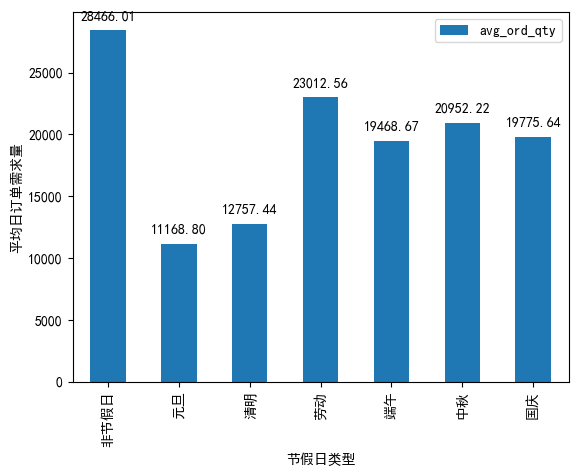

In [23]:
grouped_df = df.groupby('holiday_type').agg({'ord_qty':'sum'}).reset_index()
holiday_mapping = {0: '非节假日', 1: '元旦', 2: '春节', 3: '清明', 4:'劳动', 5:'端午', 6:'中秋', 7:'国庆'}
grouped_df['holiday_name'] = grouped_df['holiday_type'].replace(holiday_mapping)
grouped_df['avg_ord_qty'] = grouped_df.apply(lambda row: row['ord_qty'] / holidays_count_dict[row['holiday_type']], axis=1)

plt.figure(figsize=(10, 6))
ax = grouped_df.plot(x='holiday_name',y='avg_ord_qty',kind='bar')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.xlabel('节假日类型')
plt.ylabel('平均日订单需求量')
plt.show()

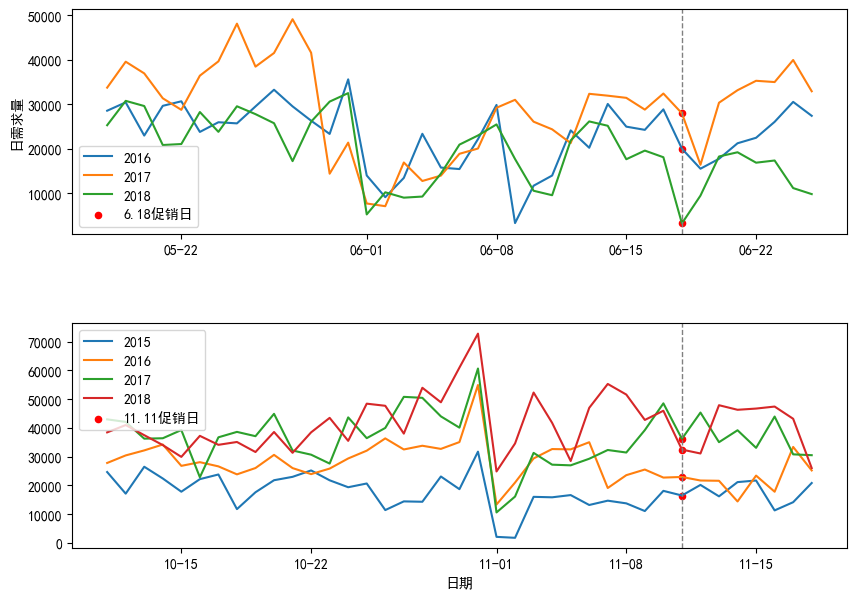

In [24]:
df['daily_date'] = df['order_date'].dt.strftime('%m-%d')
grouped_df = df.groupby(['order_date','year', 'daily_date']).agg({'ord_qty': 'sum'}).reset_index()
# 6.18附近的数据
r1_grouped_df = grouped_df.copy()
r1_grouped_df = r1_grouped_df[(r1_grouped_df['daily_date']>='05-18') & (r1_grouped_df['daily_date']<='06-25')]
r1_grouped_df['daily_date'] = pd.to_datetime(r1_grouped_df['daily_date'], format='%m-%d')
# 11.11附近的数据
r2_grouped_df = grouped_df.copy()
r2_grouped_df = r2_grouped_df[(r2_grouped_df['daily_date']>='10-11') & (r2_grouped_df['daily_date']<='11-18')].copy()
r2_grouped_df['daily_date'] = pd.to_datetime(r2_grouped_df['daily_date'], format='%m-%d')
# plt.figure(figsize=(10, 6))


fig, axs = plt.subplots(2, 1, figsize=(10, 7), sharex=False)

sales1_legend_added = False
for year, data in r1_grouped_df.groupby('year'):
    axs[0].plot(data['daily_date'], data['ord_qty'], label=str(year))
for index, row in r1_grouped_df.iterrows():
    if (row['daily_date'].month == 6) & (row['daily_date'].day == 18):
        axs[0].scatter(row['daily_date'], row['ord_qty'], marker='.', color='red', s=80, label='6.18促销日' if not sales1_legend_added else '')
        sales1_legend_added = True
axs[0].legend()
# axs[0].set_xlabel('日期')
axs[0].set_ylabel('日需求量')
axs[0].axvline(x=datetime(1900, 6, 18), color='gray', linestyle='--', linewidth=1)
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))   

sales2_legend_added = False
for year, data in r2_grouped_df.groupby('year'):
    axs[1].plot(data['daily_date'], data['ord_qty'], label=str(year))       
for index, row in r2_grouped_df.iterrows():
    if (row['daily_date'].month == 11) & (row['daily_date'].day == 11):
        axs[1].scatter(row['daily_date'], row['ord_qty'], marker='.', color='red', s=80, label='11.11促销日' if not sales2_legend_added else '')
        sales2_legend_added= True
axs[1].legend()
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
axs[1].axvline(x=datetime(1900, 11, 11), color='gray', linestyle='--', linewidth=1)
axs[1].set_xlabel('日期')
axs[0].set_ylabel('日需求量')

plt.subplots_adjust(hspace=0.4)
# 显示图表
plt.show()

### 数据处理

In [25]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [26]:
def data_processing(df):
    df['order_date'] = pd.to_datetime(df['order_date']) # 将order_date列转化为datetime64类型
    # 提取日期信息及格式化输出
    df['year'] = df['order_date'].dt.year
    df['quarter'] = df['order_date'].dt.quarter
    df['month'] = df['order_date'].dt.month
    df['week'] = df['order_date'].dt.isocalendar().week
    df['weekday'] = df['order_date'].dt.dayofweek
    df['day'] = df['order_date'].dt.day
    df['monthly_date'] = df['order_date'].dt.strftime('%Y-%m')
    df.drop_duplicates(inplace=True) # 在原始数据上去除重复行
    res_df = outlier_handle(df,['item_price','ord_qty'],2)
    res_df.reset_index(inplace=True,drop=True)
    res_df['sales_chan_code'] = res_df['sales_chan_name'].apply(lambda x:sales_chan_name_code[x])
    res_df['month_period'] = res_df['day'].apply(assign_month_period)
    res_df['sales_promotion_type'] = res_df['order_date'].apply(assign_date_number)
    res_df['is sales promotion'] = res_df['sales_promotion_type'].apply(lambda x: 1 if x != 0 else 0)
    res_df['holiday_type'] = res_df['order_date'].apply(assign_holiday_type)
    res_df['is_holiday'] = res_df['holiday_type'].apply(lambda x: 1 if x != 0 else 0)
    res_df['season'] = res_df['order_date'].apply(assign_season)
    return res_df

raw_df = pd.read_csv('data/order_train2.csv')
processed_raw_df = data_processing(raw_df)

In [40]:
def data_handling(df,type,standardized):
    '''
    type
    1:按天粒度进行汇总
    2:按周粒度进行汇总
    3:按月粒度进行汇总
    '''
    if type == 1:
        res_df = df.groupby(['order_date','sales_region_code','item_code','first_cate_code','second_cate_code','sales_chan_code','holiday_type','year','month','day','weekday','season','month_period']).agg({'item_price':'mean','ord_qty':'sum'}).reset_index()
    if type == 2:
        res_df = df.groupby(['order_date','sales_region_code','item_code','first_cate_code','second_cate_code','sales_chan_code','year','week']).agg({'item_price':'mean','ord_qty':'sum'}).reset_index()
    if type == 3:
        res_df = df.groupby(['order_date','sales_region_code','item_code','first_cate_code','second_cate_code','sales_chan_code','year','month','season']).agg({'item_price':'mean','ord_qty':'sum'}).reset_index()
    
    train_df = res_df[res_df['order_date']<'2019-1-1'].copy()
    test_df = res_df[res_df['order_date']>='2019-1-1'].copy()
    
    train_X, train_y = train_df.drop(['order_date','ord_qty'],axis=1), train_df[['ord_qty']]
    X_test, y_test = test_df.drop(['order_date','ord_qty'],axis=1), test_df[['ord_qty']]
    
    if standardized == 0:
        X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
        return X_train, X_val, y_train, y_val, X_test, y_test
    if standardized == 1:
        scaler = MinMaxScaler()
        train_y_s = scaler.fit_transform(train_y)        
        X_train, X_val, y_train, y_val = train_test_split(train_X, train_y_s, test_size=0.2, random_state=42)
        y_test_s = scaler.fit_transform(y_test)
        return X_train, X_val, y_train, y_val, X_test, y_test_s

In [41]:
# dayily_X_train, dayily_X_val, dayily_y_train, dayily_y_val, dayily_X_test, dayily_y_test = data_handling(processed_raw_df,1,0)
# weekly_X_train, weekly_X_val, weekly_y_train, weekly_y_val, weekly_X_test, weekly_y_test = data_handling(processed_raw_df,2,0)
monthly_X_train, monthly_X_val, monthly_y_train, monthly_y_val, monthly_X_test, monthly_y_test = data_handling(processed_raw_df,3,0)

# 3. XGBoost模型

In [44]:
monthly_X_train

,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_code,year,month,season,item_price
370974,105,20445,303,401,1,2018,11,3,631.000000
43018,101,21920,305,412,0,2016,3,1,762.000000
68444,104,20003,301,405,1,2016,7,2,914.000000
199551,101,22046,305,412,0,2017,8,2,1293.000000
273861,102,20221,306,407,0,2018,3,1,1792.000000
...,...,...,...,...,...,...,...,...,...
259178,102,20810,306,407,0,2018,1,4,748.500000
365838,101,20121,306,407,0,2018,11,3,1575.500000
131932,105,20582,302,408,1,2017,2,4,986.000000
146867,102,20316,301,405,0,2017,4,1,971.333333


In [43]:
monthly_y_train

array([[0.02654517],
       [0.02099842],
       [0.05269414],
       ...,
       [0.00475436],
       [0.05388273],
       [0.1026149 ]])

In [53]:
# 生成param range的函数
def get_range(start_number,end_number):
    return [start_number * (2 ** i) for i in range(int((end_number - start_number) / start_number) + 1) if start_number * (2 ** i) <= end_number]

In [63]:
max_depth_range = get_range(4,32)
hyper_params  = {
    # 'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1, 0.2, 0.4, 0.8], 
    # 'learning_rate': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7,  0.8], 
    # 'gamma': np.arange(0, 1.1, 0.1),
    'learning_rate': [0.1, 0.2, 0.4, 0.8],
    'max_depth': [4, 8, 16, 32],  # 4-10 int
    # 'reg_alpha': [0,1]+get_range(0.01,0.1),
    # 'reg_lambda': [0, 0.1, 0.5, 1],
    # 'n_estimators': get_range(50,1000), # 50-1000(50,100,200,400,800)
    # 'subsample': [0.6, 0.7, 0.8, 0.9, 1],
}

# 使用GridSearchCV进行参数优化
model = XGBRegressor(objective='reg:squarederror', early_stopping_rounds=5)
# param_search = GridSearchCV(estimator=model, param_grid=hyper_params, cv=3, scoring='neg_root_mean_squared_error')
param_search = RandomizedSearchCV(estimator=model, param_distributions=hyper_params, n_iter = 2, cv=3, scoring='neg_root_mean_squared_error', verbose=3)
param_search.fit(monthly_X_train, monthly_y_train, eval_set=[(monthly_X_val, monthly_y_val)])

print("Best parameters found: ", param_search.best_params_)
print("Lowest RMSE: ", -param_search.best_score_)

best_model = param_search.best_estimator_

Best parameters found:  {'learning_rate': 0.4, 'max_depth': 8}


In [47]:
# 对新数据进行预测
monthly_pred = best_model.predict(monthly_X_test)

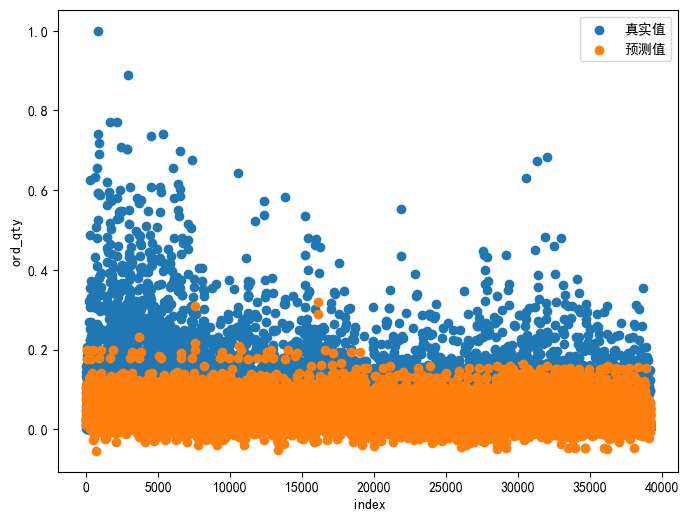

In [48]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(monthly_y_test)),monthly_y_test, label='真实值')
plt.scatter(range(len(monthly_pred)),monthly_pred, label='预测值')
plt.xlabel('index')
plt.ylabel('ord_qty')
plt.legend()
plt.show()

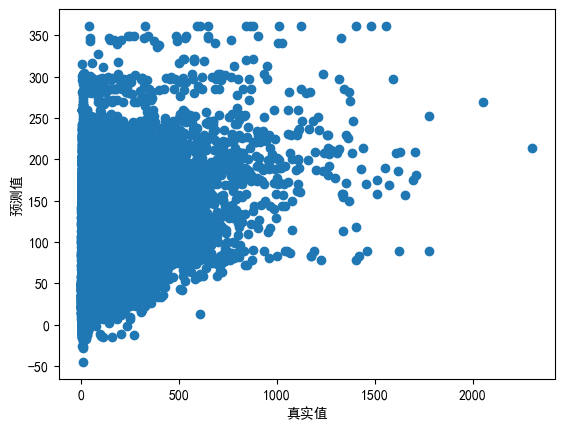

In [35]:
plt.scatter(monthly_y_test,monthly_pred)
plt.xlabel('真实值')
plt.ylabel('预测值')
plt.show()

In [51]:
from sklearn.metrics import mean_squared_error, r2_score
print(f"RMSE of the base model: {mean_squared_error(monthly_y_test, monthly_pred, squared=False)}")
print(f"R-squre of the base model: {r2_score(monthly_y_test, monthly_pred)}")

RMSE of the base model: 0.05469721315675317
R-squre of the base model: 0.16702255039232472


In [1]:
# 保存上述的xgboost模型到文件中
import pickle
pickle.dump(best_model, open('xgboost_model.pkl', 'wb'))

# 4. 随机森林模型

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf_param_grid = { 
    'min_samples_leaf': [5],
    # 'n_estimators': [50*(i+1) for i in range(int(800/50))],
    # 'min_samples_leaf': range(1,10),
    # 'max_depth' : range(4,12),
    # 'min_samples_split' :range(1,20)
}

rf = RandomForestRegressor()
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=3, scoring='neg_mean_squared_error',n_jobs=61)
rf_grid_search.fit(monthly_X_train, monthly_y_train)

# 输出最优参数组合
print("Best parameters found: ", rf_grid_search.best_params_)

# 7. 使用最优参数训练模型
best_rf_model = rf_grid_search.best_estimator_

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=61,
             param_grid={'min_samples_leaf': [5]},
             scoring='neg_mean_squared_error')

In [49]:
# 对新数据进行预测
monthly_rf_pred = best_rf_model.predict(monthly_X_test)

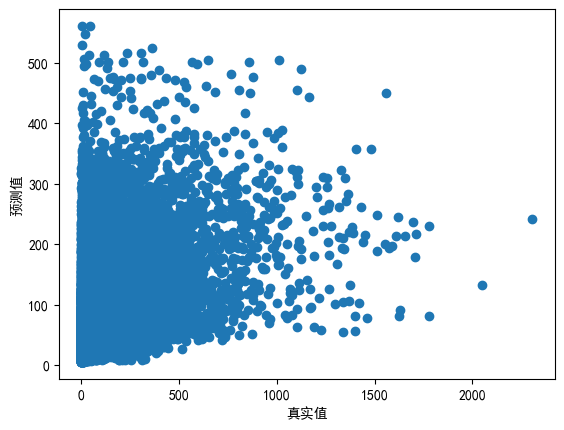

In [50]:
plt.scatter(monthly_y_test,monthly_rf_pred)
plt.xlabel('真实值')
plt.ylabel('预测值')
plt.show()

In [51]:
from sklearn.metrics import mean_squared_error, r2_score
print(f"RMSE of the base model: {mean_squared_error(monthly_y_test, monthly_rf_pred, squared=False)}")
print(f"R-squre of the base model: {r2_score(monthly_y_test, monthly_rf_pred)}")

RMSE of the base model: 126.39791439027431
R-squre of the base model: 0.1620507589389143
